## Multi-Layered Perceptrons
## Building our own Neural Framework

> This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Visit the repository for complete set of learning materials.

In this notebook, we will gradually build our own neural framework capable of solving multi-class classification tasks as well as regression with multi-layered preceptrons.

First, let's import some required libraries.

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

## Sample Dataset

As before, we will start with a simple sample dataset with two parameters.


In [3]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [4]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

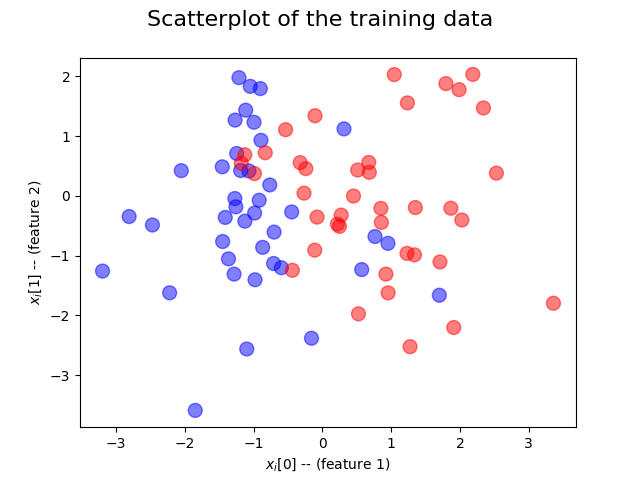

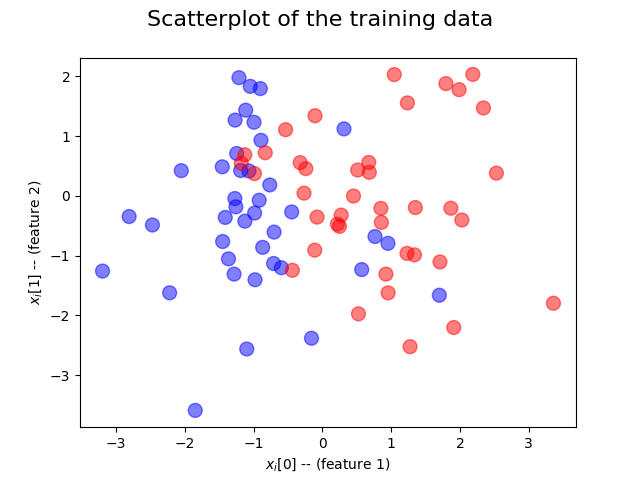

In [5]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)
plt.show()

In [6]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


## Machine Learning Problem

Suppose we have input dataset $\langle X,Y\rangle$, where $X$ is a set of features, and $Y$ - corresponding labels. For regression problem, $y_i\in\mathbb{R}$, and for classification it is represented by a class number $y_i\in\{0,\dots,n\}$. 

Any machine learning model can be represented by function $f_\theta(x)$, where $\theta$ is a set of **parameters**. Our goal is to find such parameters $\theta$ that our model fits the dataset in the best way. The criteria is defined by **loss function** $\mathcal{L}$, and we need to find optimal value

$$
\theta = \mathrm{argmin}_\theta \mathcal{L}(f_\theta(X),Y)
$$

Loss function depends on the problem being solved.

### Loss functions for regression

For regression, we often use **abosolute error** $\mathcal{L}_{abs}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$, or **mean squared error**: $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$

In [7]:
# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1,len(functions), figsize=(9, 3))
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

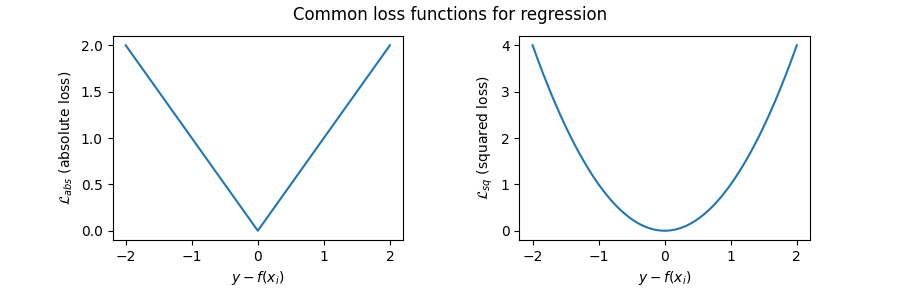

In [8]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

### Loss functions for classification

Let's consider binary classification for a moment. In this case we have two classes, numbered 0 and 1. The output of the network $f_\theta(x_i)\in [0,1]$ essentially defines the probability of choosing the class 1.

**0-1 loss**

0-1 loss is the same as calculating accuracy of the model - we compute the number of correct classifications:

$$\mathcal{L}_{0-1} = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & (f(x_i)<0.5 \land y_i=0) \lor (f(x_i)<0.5 \land y_i=1) \\
         1 & \mathrm{ otherwise}
       \end{cases} \\
$$

However, accuracy itself does not show how far are we from the right classification. It could be that we missed the correct class just by a little bit, and that is in a way "better" (in a sense that we need to correct weights much less) than missing significantly. Thus, more often logistic loss is used, which takes this into account.

**Logistic Loss**

$$\mathcal{L}_{log} = \sum_{i=1}^n -y\log(f_{\theta}(x_i)) - (1-y)\log(1-f_\theta(x_i))$$

In [9]:
x = np.linspace(0,1,100)
def zero_one(d):
    if d < 0.5:
        return 0
    return 1
zero_one_v = np.vectorize(zero_one)

def logistic_loss(fx):
    # assumes y == 1
    return -np.log(fx)

C:\Users\Tande\AppData\Local\Temp\ipykernel_9032\331859503.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.log(fx)


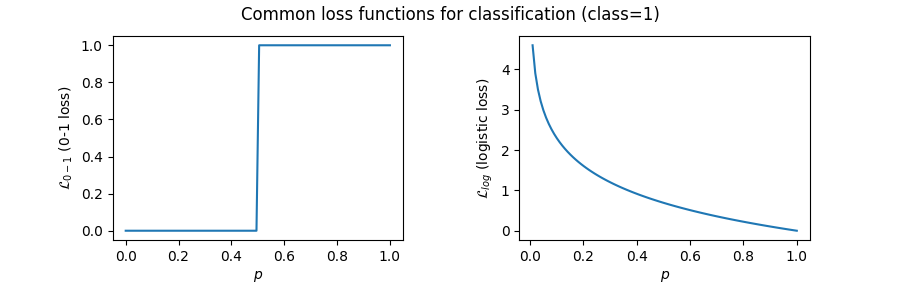

In [10]:
plot_loss_functions(suptitle = 'Common loss functions for classification (class=1)',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\\mathcal{L}_{0-1}}$ (0-1 loss)',
                                 '$\\mathcal{L}_{log}$ (logistic loss)'],
                   xlabel     = '$p$')


To understand logistic loss, consider two cases of the expected output:
* If we expect output to be 1 ($y=1$), then the loss is $-log f_\theta(x_i)$. The loss is 0 is the network predicts 1 with probability 1, and grows larger when probability of 1 gets smaller.
* If we expect output to be 0 ($y=0$), the loss is $-log(1-f_\theta(x_i))$. Here, $1-f_\theta(x_i)$ is the probability of 0 which is predicted by the network, and the meaning of log-loss is the same as described in the previous case

## Neural Network Architecture

We have generated a dataset for binary classification problem. However, let's consider it as multi-class classification right from the start, so that we can then easily switch our code to multi-class classification. In this case, our one-layer perceptron will have the following architecture:

<img src="images/NeuroArch.png" width="50%"/>

Two outputs of the network correspond to two classes, and the class with highest value among two outputs corresponds to the right solution.

The model is defined as
$$
f_\theta(x) = W\times x + b
$$
where $$\theta = \langle W,b\rangle$$ are parameters.

We will define this linear layer as a Python class with a `forward` function that performs the calculation. It receives input value $x$, and produces the output of the layer. Parameters `W` and `b` are stored within the layer class, and are initialized upon creation with random values and zeroes respectively.

In [11]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

array([[ 1.77202116, -0.25384488],
       [ 0.28370828, -0.39610552],
       [-0.30097433,  0.30513182],
       [-0.8120485 ,  0.56079421],
       [-1.23519653,  0.3394973 ]])

In many cases, it is more efficient to operate not on the one input value, but on the vector of input values. Because we use Numpy operations, we can pass a vector of input values to our network, and it will give us the vector of output values.

## Softmax: Turning Outputs into Probabilities

As you can see, our outputs are not probabilities - they can take any values. In order to convert them into probabilities, we need to normalize the values across all classes. This is done using **softmax** function: $$\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j} e^{z_j}}, \quad\mathrm{for}\quad c\in 1 .. |C|$$

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch-softmax.PNG" width="50%">

> Output of the network $\sigma(\mathbf{z})$ can be interpreted as probability distribution on the set of classes $C$: $q = \sigma(\mathbf{z}_c) = \hat{p}(c | x)$

We will define the `Softmax` layer in the same manner, as a class with `forward` function: 

In [12]:
class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10]))

array([[0.88348621, 0.11651379],
       [0.66369714, 0.33630286],
       [0.35294795, 0.64705205],
       [0.20216095, 0.79783905],
       [0.17154828, 0.82845172],
       [0.24279153, 0.75720847],
       [0.18915732, 0.81084268],
       [0.17282951, 0.82717049],
       [0.13897531, 0.86102469],
       [0.72746882, 0.27253118]])

You can see that we are now getting probabilities as outputs, i.e. the sum of each output vector is exactly 1. 

In case we have more than 2 classes, softmax will normalize probabilities across all of them. Here is a diagram of network architecture that does MNIST digit classification:

![MNIST Classifier](images/Cross-Entropy-Loss.PNG)


## Cross-Entropy Loss

A loss function in classification is typically a logistic function, which can be generalized as **cross-entropy loss**. Cross-entropy loss is a function that can calculate similarity between two arbitrary probability distributions. You can find more detailed discussion about it [on Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy).

In our case, first distribution is the probabilistic output of our network, and the second one is so-called **one-hot** distribution, which specifies that a given class $c$ has corresponding probability 1 (all the rest being 0). In such a case cross-entropy loss can be calculated as $-\log p_c$, where $c$ is the expected class, and $p_c$ is the corresponding probability of this class given by our neural network.

> If the network return probability 1 for the expected class, cross-entropy loss would be 0. The closer the probability of the actual class is to 0, the higher is cross-entropy loss (and it can go up to infinity!).

In [13]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')
    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    plt.xlabel('$\\hat{p}(y|x)$', size=18)
    plt.ylabel('$\\mathcal{L}_{CE}$', size=18)
    plt.show()

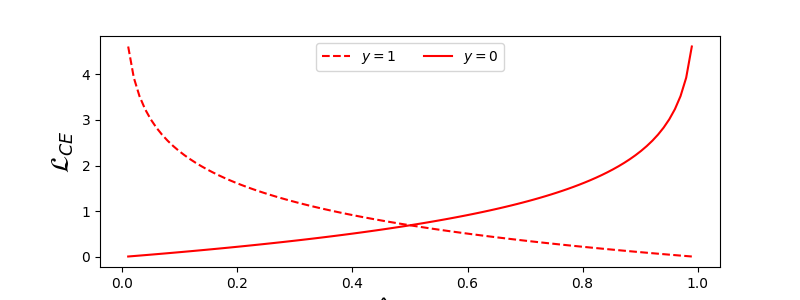

In [14]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

Cross-entropy loss will be defined again as a separate layer, but `forward` function will have two input values: output of the previous layers of the network `p`, and the expected class `y`:

In [15]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean() # average over all input samples

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

1.429664938969559

> **IMPORTANT**: Loss function returns a number that shows how good (or bad) our network performs. It should return us one number for the whole dataset, or for the part of the dataset (minibatch). Thus after calculating cross-entropy loss for each individual component of the input vector, we need to average (or add) all components together - which is done by the call to `.mean()`.

## Computational Graph

<img src="images/ComputeGraph.png" width="600px"/>

Up to this moment, we have defined different classes for different layers of the network. Composition of those layers can be represented as **computational graph**. Now we can compute the loss for a given training dataset (or part of it) in the following manner:

In [16]:
z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

1.429664938969559


## Loss Minimization Problem and Network Training

Once we have defined out network as $f_\theta$, and given the loss function $\mathcal{L}(Y,f_\theta(X))$, we can consider $\mathcal{L}$ as a function of $\theta$ under our fixed training dataset: $\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

In this case, the network training would be a minimization problem of $\mathcal{L}$ under argument $\theta$:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

There is a well-known method of function optimization called **gradient descent**. The idea is that we can compute a derivative (in multi-dimensional case call **gradient**) of loss function with respect to parameters, and vary parameters in such a way that the error would decrease.

Gradient descent works as follows:
 * Initialize parameters by some random values $w^{(0)}$, $b^{(0)}$
 * Repeat the following step many times:

 $$\begin{align}
 W^{(i+1)}&=W^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial W}\\
 b^{(i+1)}&=b^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial b}
 \end{align}
 $$

During training, the optimization steps are supposed to be calculated considering the whole dataset (remember that loss is calculated as a sum/average through all training samples). However, in real life we take small portions of the dataset called **minibatches**, and calculate gradients based on a subset of data. Because subset is taken randomly each time, such method is called **stochastic gradient descent** (SGD).
 

## Backward Propagation

<img src="images/ComputeGraph.png" width="300px" align="left"/>

$$\def\L{\mathcal{L}}\def\zz#1#2{\frac{\partial#1}{\partial#2}}
\begin{align}
\zz{\L}{W} =& \zz{\L}{p}\zz{p}{z}\zz{z}{W}\cr
\zz{\L}{b} =& \zz{\L}{p}\zz{p}{z}\zz{z}{b}
\end{align}
$$

To compute $\partial\mathcal{L}/\partial W$ we can use the **chaining rule** for computing derivatives of a composite function, as you can see in the formulae above. It corresponds to the following idea:

* Suppose under given input we have obtanes loss $\Delta\mathcal{L}$
* To minimize it, we would have to adjust softmax output $p$ by value $\Delta p = (\partial\mathcal{L}/\partial p)\Delta\mathcal{L}$  
* This corresponds to the changes to node $z$ by $\Delta z = (\partial\mathcal{p}/\partial z)\Delta p$
* To minimize this error, we need to adjust parameters accordingly: $\Delta W = (\partial\mathcal{z}/\partial W)\Delta z$ (and the same for $b$)

<img src="images/ComputeGraphGrad.PNG" width="400px" align="right"/>

This process starts distributing the loss error from the output of the network back to its parameters. Thus the process is called **back propagation**.

One pass of the network training consists of two parts:
* **Forward pass**, when we calculate the value of loss function for a given input minibatch
* **Backward pass**, when we try to minimize this error by distributing it back to the model parameters through the computational graph.

### Implementation of Back Propagation

* Let's add `backward` function to each of our nodes that will compute the derivative and propagate the error during the backward pass.
* We also need to implement parameter updates according to the procedure described above

We need to compute derivatives for each layer manually, for example for linear layer $z = x\times W+b$:
$$\begin{align}
\frac{\partial z}{\partial W} &= x \\
\frac{\partial z}{\partial b} &= 1 \\
\end{align}$$

If we need to compensate for the error $\Delta z$ at the output of the layer, we need to update the weights accordingly:
$$\begin{align}
\Delta x &= \Delta z \times W \\
\Delta W &= \frac{\partial z}{\partial W} \Delta z = \Delta z \times x \\
\Delta b &= \frac{\partial z}{\partial b} \Delta z = \Delta z \\
\end{align}$$

**IMPORTANT:** Calculations are done not for each training sample independently, but rather for a whole **minibatch**. Required parameter updates $\Delta W$ and $\Delta b$ are computed across the whole minibatch, and the respective vectors have dimensions: $x\in\mathbb{R}^{\mathrm{minibatch}\, \times\, \mathrm{nclass}}$

In [17]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In the same manner we can define `backward` function for the rest of our layers:

In [18]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

## Training the Model

Now we are ready to write the **training loop**, which will go through our dataset, and perform the optimization minibatch by minibatch.One complete pass through the dataset is often called **an epoch**:

In [19]:
lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

learning_rate = 0.1

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
    
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(learning_rate)
    
pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)
    

Initial accuracy:  0.725
Final accuracy:  0.825


Nice to see how we can increase accuracy of the model from about 50% to around 80% in one epoch.

## Network Class

Since in many cases neural network is just a composition of layers, we can build a class that will allow us to stack layers together and make forward and backward passes through them without explicitly programming that logic. We will store the list of layers inside the `Net` class, and use `add()` function to add new layers:

In [20]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

With this `Net` class our model definition and training becomes more neat:

In [21]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(test_x,test_labels)))

Initial loss=0.6212072429381601, accuracy=0.6875: 
Final loss=0.44369925927417986, accuracy=0.8: 
Test loss=0.4767711377257787, accuracy=0.85: 


## Plotting the Training Process

It would be nice to see visually how the network is being trained! We will define a `train_and_plot` function for that. To visualize the state of the network we will use level map, i.e. we will represent different values of the network output using different colors.

> Do not worry if you do not understand some of the plotting code below - it is more important to understand the underlying neural network concepts.

In [22]:
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

In [23]:
import matplotlib.cm as cm

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # remove previous plot
    while ax.collections:
        ax.collections.pop()
        draw_colorbar = False

    # generate countour grid
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # pad dimensions (plot only the first two)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(net.forward(grid_points))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [24]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

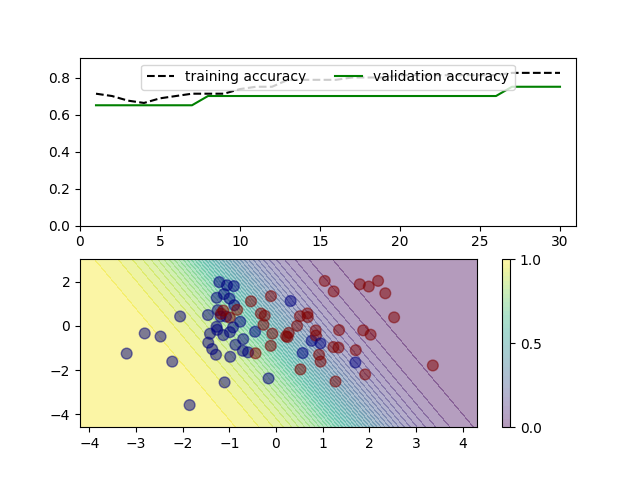

In [31]:
%matplotlib widget 
net = Net()
net.add(Linear(2,2))
net.add(Softmax())

res = train_and_plot(30,net,lr=0.005)

After running the cell above you should be able to see interactively how the boundary between classes change during training. Note that we have chosen very small learning rate so that we can see how the process happens.

## Multi-Layered Models

The network above has been constructed from several layers, but we still had only one `Linear` layer, which does the actual classification. What happens if we decide to add several such layers?

Surprisingly, our code will work! Very important thing to note, however, is that in between linear layers we need to have a non-linear **activation function**, such as `tanh`. Without such non-linearity, several linear layers would have the same expressive power as just one layers - because composition of linear functions is also linear!

In [26]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

 Adding several layers make sense, because unlike one-layer network, multi-layered model will be able to accuratley classify sets that are not linearly separable. I.e., a model with several layers will be **reacher**.

> It can be demonstrated that with sufficient number of neurons a two-layered model is capable to classifying any convex set of data points, and three-layered network can classify virtually any set.

Mathematically, multi-layered perceptron would be represented by a more complex function $f_\theta$ that can be computed in several steps:
* $z_1 = W_1\times x+b_1$
* $z_2 = W_2\times\alpha(z_1)+b_2$
* $f = \sigma(z_2)$

Here, $\alpha$ is a **non-linear activation function**, $\sigma$ is a softmax function, and $\theta=\langle W_1,b_1,W_2,b_2\rangle$ are parameters.

The gradient descent algorithm would remain the same, but it would be more difficult to calculate gradients. Given the
 chain differentiation rule, we can calculate derivatives as:

$$\begin{align}
\frac{\partial\mathcal{L}}{\partial W_2} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial W_2}} \\
\frac{\partial\mathcal{L}}{\partial W_1} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial\alpha}\frac{\partial\alpha}{\partial z_1}\frac{\partial z_1}{\partial W_1}}
\end{align}
$$

Note that the beginning of all those expressions is still the same, and thus we can continue back propagation beyond one linear layers to adjust further weights up the computational graph.

Let's now experiment with two-layered network:

In [33]:
net = Net()
net.add(Linear(2,10))
net.add(Tanh())
net.add(Linear(10,2))
net.add(Softmax())
loss = CrossEntropyLoss()

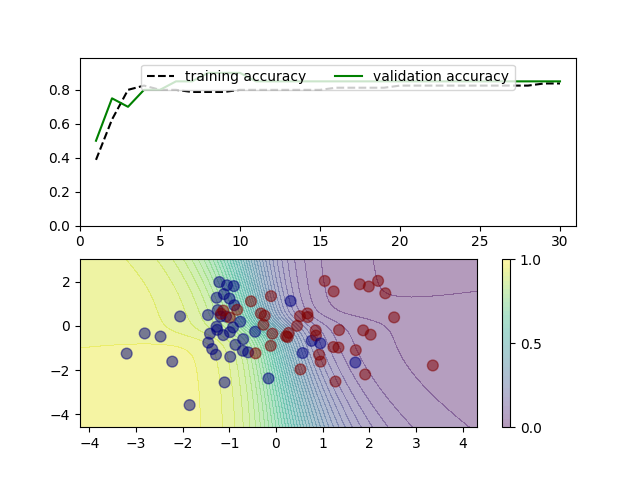

In [34]:
res = train_and_plot(30,net,lr=0.01)

## Why Not Always Use Multi-Layered Model?

We have seen that multi-layered model is more *powerful* and *expressive*, than one-layered one. You may be wondering why don't we always use many-layered model. The answer to this question is **overfitting**.

We will deal with this term more in a later sections, but the idea is the following: **the more powerful the model is, the better it can approximate training data, and the more data it needs to properly generalize** for the new data it has not seen before.

**A linear model:**
* We are likely to get high training loss - so-called **underfitting**, when the model does not have enough power to correctly separate all data. 
* Valiadation loss and training loss are more or less the same. The model is likely to generalize well to test data.

**Complex multi-layered model**
* Low training loss - the model can approximate training data well, because it has enough expressive power.
* Validation loss can be much higher than training loss and can start to increase during training - this is because the model "memorizes" training points, and loses the "overall picture"

![Overfitting](images/overfit.png)

> On this picture, `x` stands for training data, `o` - validation data. Left - linear model (one-layer), it approximates the nature of the data pretty well. Right - overfitted model, the model perfectly well approximates training data, but stops making sense with any other data (validation error is very high)

## Takeaways

* Simple models (fewer layers, fewer neurons) with low number of parameters ("low capacity") are less likely to overfit
* More complex models (more layers, more neurons on each layer, high capacity) are likely to overfit. We need to monitor validation error to make sure it does not start to rise with further training
* More complex models need more data to train on.
* You can solve overfitting problem by either:
    - simplifying your model
    - increasing the amount of training data
* **Bias-variance trade-off** is a term that shows that you need to get the compromise
    - between power of the model and amount of data,
    - between overfittig and underfitting
* There is not single recipe on how many layers of parameters you need - the best way is to experiment

## Credits

This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners), and has been prepared by [Dmitry Soshnikov](http://soshnikov.com). It is inspired by Neural Network Workshop at Microsoft Research Cambridge. Some code and illustrative materials are taken from presentations by [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) and [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/), and from [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) repository.